### A CNN classifier for the images from CIFAR 10 dataset

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms

#### Dowload the CIFAR 10 dataset

In [2]:
trainset = torchvision.datasets.CIFAR10(root='.\datasets', train=True, download=True, transform = transforms.ToTensor())

0it [00:00, ?it/s]

170500096it [01:39, 1196969.37it/s]                                                                                    

In [5]:
testset = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform = transforms.ToTensor())

Files already downloaded and verified


In [9]:
traindataloader = torch.utils.data.DataLoader(trainset, batch_size = 10, num_workers=2, shuffle=True)

In [12]:
testdataloader = torch.utils.data.DataLoader(testset, batch_size = 10, shuffle=True, num_workers = 2)

In [13]:
labels = ('plane', 'car', 'bird', 'cat','deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

#### Analysing the dataset

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
images_batch, labels_batch = iter(traindataloader).next()

In [37]:
img = torchvision.utils.make_grid(images_batch)

In [38]:
img.shape

torch.Size([3, 70, 274])

In [39]:
img = np.transpose(img, (1,2, 0))
img.shape

torch.Size([70, 274, 3])

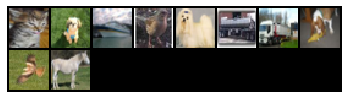

In [40]:
plt.imshow(img)
plt.axis('off')
plt.show()

#### Building our nn

In [41]:
import torch.nn as nn

In [118]:
# defining the depth for the 3 conv layers
# Pytorch infers automatically the width and height of the conv volume

in_size = 3
hidden_1_size = 16 
hidden_2_size = 32 
out_size = len(labels)
kernel_dim = 3 # what is this ?

In [120]:
class ConvNet (nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hidden_1_size, kernel_dim),
            nn.BatchNorm2d(hidden_1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_1_size, hidden_2_size, kernel_dim),
            nn.BatchNorm2d(hidden_2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # hidden_2_size is the detpth of the last volume, and kernel_size x kernel_size is
        # the dimension of the layer after 2 conv and 2 max pooling layers
        self.fc = nn.Linear(hidden_2_size * 6 * 6, out_size) 
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) # flatten the layer 
        out = self.fc(out)
        
        return out
        
    

In [121]:
model = ConvNet()

In [72]:
for hue in model.parameters():
    print(hue.shape)

torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([10, 800])
torch.Size([10])


In [79]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # the loss function
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#### Training the model

In [122]:
total_step = len(traindataloader)
num_epochs = 5
loss_history = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(traindataloader):
        
        outputs = model(images) # processing a batch
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%2000 == 0:
            loss_history.append(loss.item())
            print('Epoch [{}/{}]  Step [{}/{}]  Loss {} '.format(
            epoch+1, num_epochs, i+1, total_step, loss.item() )) # here we get the current loss
            


Epoch [1/5]  Step [2000/5000]  Loss 2.300748348236084 
Epoch [1/5]  Step [4000/5000]  Loss 2.211148738861084 
Epoch [2/5]  Step [2000/5000]  Loss 2.4578919410705566 
Epoch [2/5]  Step [4000/5000]  Loss 2.2260847091674805 
Epoch [3/5]  Step [2000/5000]  Loss 2.341975450515747 
Epoch [3/5]  Step [4000/5000]  Loss 2.454763174057007 
Epoch [4/5]  Step [2000/5000]  Loss 2.3049440383911133 
Epoch [4/5]  Step [4000/5000]  Loss 2.3145365715026855 
Epoch [5/5]  Step [2000/5000]  Loss 2.3328585624694824 
Epoch [5/5]  Step [4000/5000]  Loss 2.5440385341644287 


In [98]:
log = "Epoch [1/5]  Step [2000/5000]  Loss 1.564078688621521 \
Epoch [1/5]  Step [4000/5000]  Loss 1.524127721786499 \
Epoch [2/5]  Step [2000/5000]  Loss 1.3159184455871582 \
Epoch [2/5]  Step [4000/5000]  Loss 1.1049768924713135 \
Epoch [3/5]  Step [2000/5000]  Loss 1.333801507949829 \
Epoch [3/5]  Step [4000/5000]  Loss 0.9997671842575073 \
Epoch [4/5]  Step [2000/5000]  Loss 0.4578862190246582 \
Epoch [4/5]  Step [4000/5000]  Loss 0.8836297988891602 \
Epoch [5/5]  Step [2000/5000]  Loss 0.6459854245185852 \
Epoch [5/5]  Step [4000/5000]  Loss 0.5622429251670837"

log = log.split(' ')
loss_history = []
for i in range(len(log) -1):
    if log[i] == 'Loss':
        loss_history.append(float(log[i+1]))
        


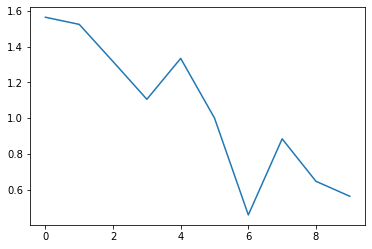

In [101]:

plt.plot(loss_history)
plt.show()

In [84]:
st = "0.5622429251670837"
a = float(st)

In [103]:
model.eval() # changes the state of the model to eval mode

with torch.no_grad():
    correct  = 0
    total = 0
    
    for images, labels in testdataloader:
        outputs = model(images)
        
        _ , predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the 10000 test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the 10000 test images: 68.31%


In [113]:
labels.size(0)



10